# Packages Imports

In [1]:
import pandas as pd
pd.set_option('display.max_rows', 130)
import numpy as np

import dask.dataframe as dd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.model_selection import train_test_split
from sklearn.metrics import (classification_report,
                             confusion_matrix)


# Neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.callbacks import EarlyStopping,LearningRateScheduler
from tensorflow.keras.utils import to_categorical


from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


# Read the data

In [66]:
INSIDER_SENARIOS = {
    0: 'Normal',
    1: 'Leaking Data',
    2: 'Churning Employee',
    3: 'Key Logging',
}

In [67]:
BALANCED_PATH = "/content/drive/MyDrive/cs_data/sessionr4.2_balanced/"

In [68]:
cert_balanced = dd.read_parquet(BALANCED_PATH)
cert_balanced = cert_balanced.repartition(npartitions=5)

In [85]:
low_cardinality_cols = [
    "b_unit",
    "file_mean_file_depth",
    "file_n_otherf",
    "file_otherf_mean_file_len",
    "file_otherf_mean_file_depth",
    "file_otherf_mean_file_nwords",
    "file_otherf_n-disk0",
    "file_otherf_n-disk1",
    "file_otherf_n-disk2",
    "file_compf_mean_file_depth",
    "file_phof_mean_file_depth",
    "file_docf_mean_file_depth",
    "file_txtf_mean_file_depth",
    "file_exef_mean_file_depth",
]

info_cols = ["subs_ind", "starttime", "endtime", "sessionid", "user", "day", "week"]

for column in low_cardinality_cols + info_cols:
    cert_balanced = cert_balanced.drop(column, axis=1, errors='ignore')

cert_balanced["duration"] = cert_balanced["duration"] / cert_balanced["duration"].max()


In [87]:
X_train = cert_balanced.drop(["insider"], axis=1).compute()
y_train = cert_balanced["insider"].compute()
X_test = pd.read_parquet("/content/drive/MyDrive/cs_data/X_test.parquet").to_numpy()
y_test = pd.read_parquet("/content/drive/MyDrive/cs_data/y_test.parquet").to_numpy()

In [88]:
y_train = to_categorical(y_train, num_classes=4)

In [89]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((589458, 107), (589458, 4), (1158914, 107), (1158914, 1))

# Neural Network

In [72]:
def print_report(y_true, y_pred):
    """
    Print the classification report

    Parameters
    ----------
    y_true: array-like
        Actual values
    y_pred: array-like
        Predicted values
    """
    print(classification_report(y_true, y_pred, zero_division=0))


def plot_cm(y_true, y_pred, labels=None, data_name=None):
    """
    Plot the confusion matrix

    Parameters
    ----------
    y_true: array-like
        Actual values
    y_pred: array-like
        Predicted values
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    if labels is None:
        sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
    else:
        sns.heatmap(
            cm, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels
        )
    if data_name is not None:
        plt.title(f"Confusion Matrix for {data_name} Data")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")


def get_results(y_true, y_pred, labels=None, data_name=None):
    """
    Print the classification report and plot the confusion matrix

    Parameters
    ----------
    y_true: array-like
        Actual values
    y_pred: array-like
        Predicted values
    """
    print_report(y_true, y_pred)
    plot_cm(y_true, y_pred, labels, data_name)
    plt.show()

def predict_in_chunks(model, dask_df):
    # Iterator to process the DataFrame in chunks
    predictions = pd.DataFrame()

    for i in range(dask_df.npartitions):
        partition = dask_df.get_partition(i).compute()
        partition_y_pred = pd.DataFrame(model.predict(partition),
                                        index=partition.index)
        predictions = pd.concat([predictions, partition_y_pred])
        del partition

    return predictions.apply(np.argmax, axis=1)

In [91]:
nn_model = Sequential()
nn_model.add(Dense(128, activation="relu", input_shape=(X_train.shape[1],)))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(64))
nn_model.add(BatchNormalization())
nn_model.add(ReLU())
nn_model.add(Dropout(0.2))

nn_model.add(Dense(32, activation="relu"))
nn_model.add(Dropout(0.2))

nn_model.add(Dense(4, activation="softmax"))


In [92]:
nn_model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
)

lr_scheduler = LearningRateScheduler(
    lambda epoch, lr: lr if epoch < 10 else lr * tf.math.exp(-0.1),
    verbose=0

)

nn_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_48 (Dense)            (None, 128)               13824     
                                                                 
 dropout_39 (Dropout)        (None, 128)               0         
                                                                 
 dense_49 (Dense)            (None, 64)                8256      
                                                                 
 batch_normalization_9 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 re_lu_9 (ReLU)              (None, 64)                0         
                                                                 
 dropout_40 (Dropout)        (None, 64)                0         
                                                      

In [94]:
history = nn_model.fit(
    X_train,
    y_train,
    epochs=20,
    batch_size=128,
    validation_split=0.2,
    class_weight={0:1, 1:10, 2:10, 3:10},
    callbacks = [early_stop, lr_scheduler]
)

Epoch 1/20
3685/3685 [==============================] - 17s 5ms/step - loss: 0.3591 - accuracy: 0.9644 - val_loss: 0.1723 - val_accuracy: 0.9515 - lr: 8.1873e-04
Epoch 2/20
3685/3685 [==============================] - 17s 5ms/step - loss: 0.3007 - accuracy: 0.9777 - val_loss: 0.1674 - val_accuracy: 0.9513 - lr: 8.1873e-04
Epoch 3/20
3685/3685 [==============================] - 17s 5ms/step - loss: 0.2890 - accuracy: 0.9779 - val_loss: 0.1698 - val_accuracy: 0.9503 - lr: 8.1873e-04
Epoch 4/20
3685/3685 [==============================] - 17s 5ms/step - loss: 0.2810 - accuracy: 0.9776 - val_loss: 0.1593 - val_accuracy: 0.9538 - lr: 8.1873e-04
Epoch 5/20
3685/3685 [==============================] - 17s 5ms/step - loss: 0.2751 - accuracy: 0.9777 - val_loss: 0.1613 - val_accuracy: 0.9535 - lr: 8.1873e-04
Epoch 6/20
3685/3685 [==============================] - 17s 5ms/step - loss: 0.2690 - accuracy: 0.9767 - val_loss: 0.1544 - val_accuracy: 0.9565 - lr: 8.1873e-04
Epoch 7/20
3685/3685 [======

In [95]:
nn_model.save("/content/drive/MyDrive/cs_data/balanced_nn_model.keras")

In [96]:
def print_report(y_true, y_pred):
    """
    Print the classification report

    Parameters
    ----------
    y_true: array-like
        Actual values
    y_pred: array-like
        Predicted values
    """
    print(classification_report(y_true, y_pred, zero_division=0))


def plot_cm(y_true, y_pred, labels=None, data_name=None):
    """
    Plot the confusion matrix

    Parameters
    ----------
    y_true: array-like
        Actual values
    y_pred: array-like
        Predicted values
    """
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(7, 5))
    if labels is None:
        sns.heatmap(cm, annot=True, fmt="g", cmap="Blues")
    else:
        sns.heatmap(
            cm, annot=True, fmt="g", cmap="Blues", xticklabels=labels, yticklabels=labels
        )
    if data_name is not None:
        plt.title(f"Confusion Matrix for {data_name} Data")
    plt.xticks(rotation=45, ha="right")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")


def get_results(y_true, y_pred, labels=None, data_name=None):
    """
    Print the classification report and plot the confusion matrix

    Parameters
    ----------
    y_true: array-like
        Actual values
    y_pred: array-like
        Predicted values
    """
    print_report(y_true, y_pred)
    plot_cm(y_true, y_pred, labels, data_name)
    plt.show()

def predict_in_chunks(model, dask_df):
    # Iterator to process the DataFrame in chunks
    predictions = pd.DataFrame()

    for i in range(dask_df.npartitions):
        partition = dask_df.get_partition(i).compute()
        partition_y_pred = pd.DataFrame(model.predict(partition),
                                        index=partition.index)
        predictions = pd.concat([predictions, partition_y_pred])
        del partition

    return predictions.apply(np.argmax, axis=1)

18421/18421 [==============================] - 30s 2ms/step
              precision    recall  f1-score   support

           0       0.99      0.98      0.99    578348
           1       1.00      0.81      0.89       431
           2       0.28      0.40      0.33     10463
           3       0.84      0.42      0.56       216

    accuracy                           0.97    589458
   macro avg       0.78      0.65      0.69    589458
weighted avg       0.98      0.97      0.97    589458



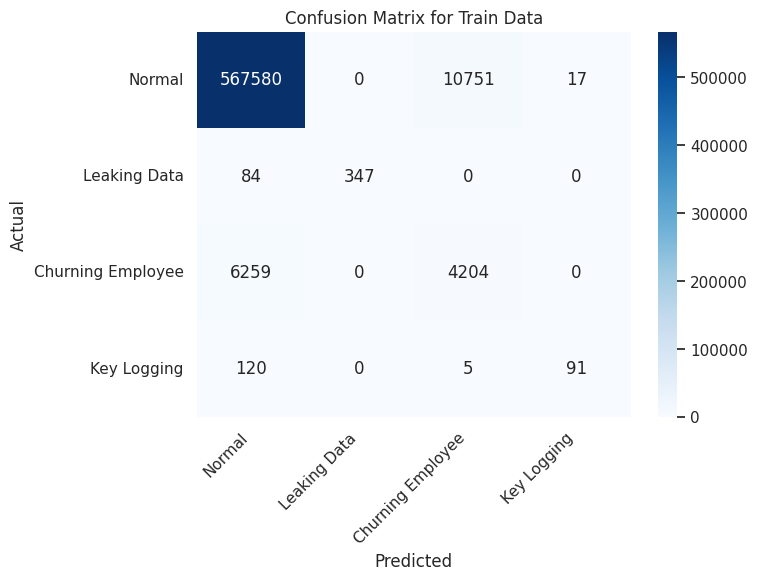

In [97]:
y_pred = nn_model.predict(X_train)

get_results(
    np.argmax(y_train, axis=1),
    np.argmax(y_pred, axis=1),
    labels=INSIDER_SENARIOS.values(),
    data_name="Train"
)

36217/36217 [==============================] - 59s 2ms/step
              precision    recall  f1-score   support

           0       1.00      0.94      0.97   1156692
           1       0.01      0.81      0.02        86
           2       0.02      0.27      0.03      2093
           3       0.00      0.81      0.00        43

    accuracy                           0.94   1158914
   macro avg       0.26      0.71      0.26   1158914
weighted avg       1.00      0.94      0.97   1158914



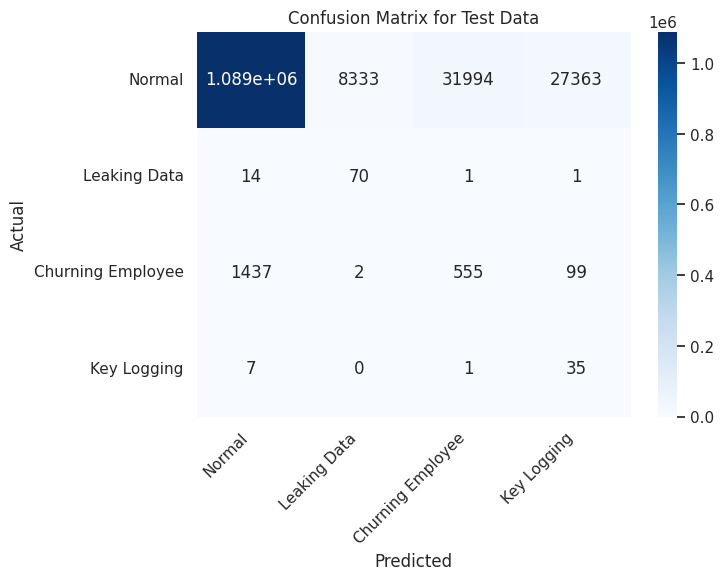

In [79]:
y_pred = nn_model.predict(X_test)

get_results(
    y_test,
    np.argmax(y_pred, axis=1),
    labels=INSIDER_SENARIOS.values(),
    data_name="Test"
)